Before we can use the camera images (test images and videos) we have to perform the camera calibration. The next cell uses the provided calibration images to compute a set of parameters which will be used later to compensate for optical distortion.

In [7]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)               # Read to RGB pixel format
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
 
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
# Clean up workspace: keep only objpoints and imgpoints
del corners, gray, images, objp

The code cell above creates the two lists `objpoints` and `imgpoints` of matching 3D to 2D (pixel) coordinate pairs. This data is the input of the `calibrateCamera` function, which calculates the parameter set we need to undistort the images. Note that 3D coordinates are in an arbitrary set of axes, and in our case, the axes are local to the chessboard pattern, giving integer coordinates (0,0,0) to (8,5,0). All the points are in the Z=0 plane, which is the plane of the chessboard.

The code cell below computes and saves the calibration parameters `mtx` and `dist`, applies them to a test image which is saved and displayed, and cleans up the workspace.

In [504]:
# objpoints : nb images x nb corners x xyz
# imgpoints : nb images x nb corners x 1 x xy
print(mtx.shape)
print(type(dist))

(3, 3)
<class 'numpy.ndarray'>


In [568]:
class CameraCalibration(object):
    """
    CameraCalibration is a record holding camera calibration data.
    Each RoadImage references a CameraCalibration record, or None (if there is no distortion)
    Usage:
        cal1 = CameraCalibration(mtx=matrix, dist=distortion)
        cal1 = CameraCalibration(objpoints, imgpoints, img_size, flags)
        cal2 = CameraCalibration(cal1)
        cal1.save(<file>)
        cal2 = CameraCalibration(<file>)
    """
    import pickle
    import cv2
    import numpy as np
    
    _instances = []   # Keep track of existing instances
    _limit = None     # Set or get limit to access maximum number of instances
    _count = 0        # Count instances
        
    def __new__(cls, *args, **kwargs):
        
        # Search kwargs and initialize arguments
        mtx = kwargs.get('mtx',None)
        dist = kwargs.get('dist',None)
        objpoints = kwargs.get('objpoints',None)
        imgpoints = kwargs.get('imgpoints',None)
        img_size = kwargs.get('img_size',None)
        flags = kwargs.get('flags',0)
        file = kwargs.get('file',None)
        error = None
        size = None
        # Purge known keys
        keys = ['mtx', 'dist', 'objpoints', 'imgpoints', 'img_size', 'flags', 'file']
        keys_to_keep = set(kwargs.keys()) - set(keys)
        kkwargs = {k: kwargs[k] for k in keys_to_keep}
        
        # kwargs contains nothing useful, hence purged kkwargs has the same length
        no_dict = (len(kwargs) == len(kkwargs))
        
        # Check invalid arguments
        if len(kkwargs) > 0: raise TypeError('CameraCalibration: invalid argument %s' % kkwargs.keys())
            
        # Associate unnamed arguments
        # Expected order is objpoints, imgpoints, img_size, mtx, dist (many alternate order will work)
        for arg in args:
            if type(arg) is list: # imgpoints or objpoints
                listdim = np.array(arg).ndim
                if listdim == 3:
                    if objpoints is None: objpoints = arg
                elif listdim == 4:
                    if imgpoints is None: imgpoints = arg
                else: raise ValueError('CameraCalibration: invalid argument %s' % str(arg))
            elif type(arg) is tuple and len(arg) == 2 and img_size is None: img_size = arg
            elif type(arg) is np.ndarray:  # mtx or dist
                arrshape = arg.shape
                if arrshape == (3,3):
                    if mtx is None: mtx = arg
                elif arrshape == (1,5):
                    if dist is None: dist = arg
                else: raise ValueError('CameraCalibration: invalid argument %s' % str(arg))
            elif type(arg) is int and flags == 0: flags = arg
            elif type(arg) is CameraCalibration and len(args)==1 and no_dict:
                mtx  = arg.matrix
                dist = arg.distortion
                error= arg.error
                size = arg.size    # Numpy order (height,width)
            elif type(arg) is str and len(args)==1 and no_dict: file = arg 
            else: raise ValueError('CameraCalibration: invalid argument %s' % str(arg))

        # Call cv2 if minimum set of mandatory arguments have been provided
        if objpoints and imgpoints and img_size:
            error, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, mtx, dist, flags=flags)
            size = (img_size[1], img_size[0])
                
        if not (file is None):
            # Read instance from file
            with open(file, 'rb') as f:
                dist_pickle = pickle.load(f)
                mtx = dist_pickle.get('mtx', mtx)
                dist = dist_pickle.get('dist', dist)
                error = dist_pickle.get('error', error)
                size = dist_pickle.get('size', img_size)

        # Search in _instances
        if mtx.shape==(3,3) and dist.shape==(1,5):
            for cc in cls._instances:
                if (cc.matrix == mtx).all() and (cc.distortion == dist).all(): return cc

        # Can make new one? 
        if not(cls._limit is None):
            if cls._count >= cls._limit: raise RuntimeError('CameraCalibration: too many instances')
        # Make new instance
        obj = super(CameraCalibration, cls).__new__(cls)
        # Last chance to fail. Be tolerant to missing error and img_size values.        
        if (mtx is None) or (dist is None): raise ValueError('CameraCalibration: initialization failed.') 
        cls._count += 1      # Space reservation
        # Initialize instance
        obj.matrix = mtx
        obj.distortion = dist
        obj.error = error
        if size: obj.size = size
        else:    obj.size = img_size
        # Reference instance
        cls._instances.append(obj)
        return obj
                
    @classmethod
    def getLimit(cls):
        return cls._limit
        
    @classmethod
    def setLimit(cls,lim):
        if lim is None: cls._limit = None
        else:
            # Set limit cannot be used to delete instances
            if lim < cls._count: raise ValueError('CameraCalibration limit cannot be less than current count.')
            cls._limit = lim
        
    @classmethod
    def getCount(cls):
        return cls._count

    def save(self,file):
        # Save the camera calibration result for later use 
        dist_pickle = {}
        dist_pickle["mtx"] = self.matrix
        dist_pickle["dist"] = self.distortion
        dist_pickle["error"] = self.error
        dist_pickle["size"] = self.size
        pickle.dump( dist_pickle, open(file, 'wb') ) 

    def undistort(self, image):
        if self.size and self.size != image.shape[:2]:
            msg = 'CameraCalibration.undistort: image size {0} does not match calibration data {1}.'
            raise ValueError(msg.format(str(image.shape[:2]),str(self.size)))
        return cv2.undistort(image, self.matrix, self.distortion, None, self.matrix)
            
# Demonstration
CameraCalibration.setLimit(2)
print('Creating cal1',end='')
cal1 = CameraCalibration(objpoints, imgpoints, img_size)
print('... mean error =',cal1.error,'\nStored calibrations: ',CameraCalibration.getCount())
cal1.save('camera_cal/example.p')
print('Creating cal2 based on cal1',end='')
cal2 = CameraCalibration(cal1)
print('... mean error =',cal2.error,'\nStored calibrations: ',CameraCalibration.getCount())
print('Creating cal3 like cal1',end='')
cal3 = CameraCalibration(objpoints, imgpoints, img_size)
print('... mean error =',cal3.error,'\nStored calibrations: ',CameraCalibration.getCount())
print('Creating cal4 from cal3 matrix and distortion',end='')
cal4 = CameraCalibration(cal3.matrix, cal3.distortion)
print('... mean error =',cal4.error,'\nStored calibrations: ',CameraCalibration.getCount())
print('Creating cal5 from arbitrary matrix',end='')
cal5 = CameraCalibration(-cal3.matrix, cal3.distortion)
print('... mean error =',cal5.error,'\nStored calibrations: ',CameraCalibration.getCount())
try:
    print('Creating cal6 from arbitrary matrix and distortion, and hit limit.')
    cal6 = CameraCalibration(cal3.matrix, -cal3.distortion)
except RuntimeError:
    print('Too many CameraCalibration instances have been created!')
print('Stored calibrations: ',CameraCalibration.getCount())
print('Creating cal7 from file',end='')
cal7 = CameraCalibration('camera_cal/example.p')
print('... mean error =',cal7.error,'\nStored calibrations: ',CameraCalibration.getCount())
CameraCalibration.setLimit(None)
del cal1, cal2, cal3, cal4, cal5

Creating cal1... mean error = 1.1868973603423725 
Stored calibrations:  1
Creating cal2 based on cal1... mean error = 1.1868973603423725 
Stored calibrations:  1
Creating cal3 like cal1... mean error = 1.1868973603423725 
Stored calibrations:  1
Creating cal4 from cal3 matrix and distortion... mean error = 1.1868973603423725 
Stored calibrations:  1
Creating cal5 from arbitrary matrix... mean error = None 
Stored calibrations:  2
Creating cal6 from arbitrary matrix and distortion, and hit limit.
Too many CameraCalibration instances have been created!
Stored calibrations:  2
Creating cal7 from file... mean error = 1.1868973603423725 
Stored calibrations:  2


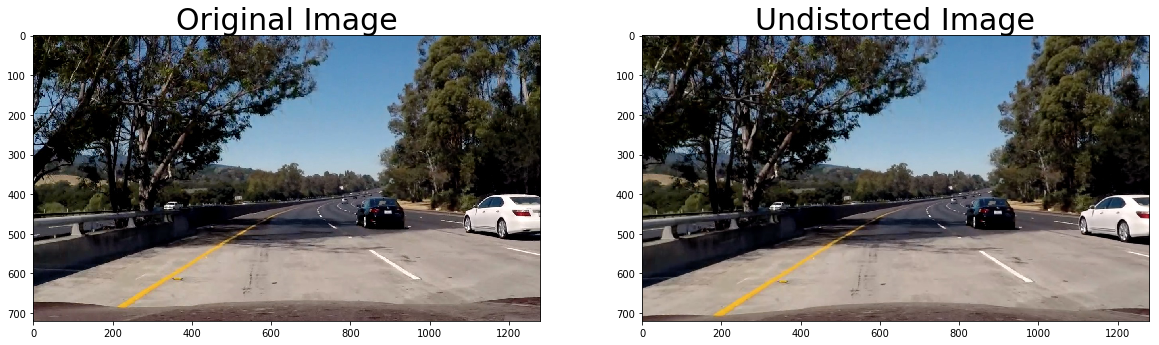

In [571]:
import pickle
import matplotlib.pyplot as plt

# Test undistortion on an image
img = mpimg.imread('test_images/test5.jpg')    # Read to RGB pixel format 
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
# Calibration is also relative to a given image size
cal = CameraCalibration(objpoints, imgpoints, img_size)

dst = cal.undistort(img)
mpimg.imsave('output_images/test5_undistorted.png',dst,format='png')

# Save the camera calibration result for later use 
cal.save( "camera_cal/wide_dist_pickle.p")

%matplotlib inline

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Clean up workspace: keep only img_size, mtx and dist (and objpoints and imgpoints too)
del ax1, ax2, f, dst, img 

The function below selects pixels based on their color in a user-chosen colorspace. What is actually does, is just threshold a single channel image.

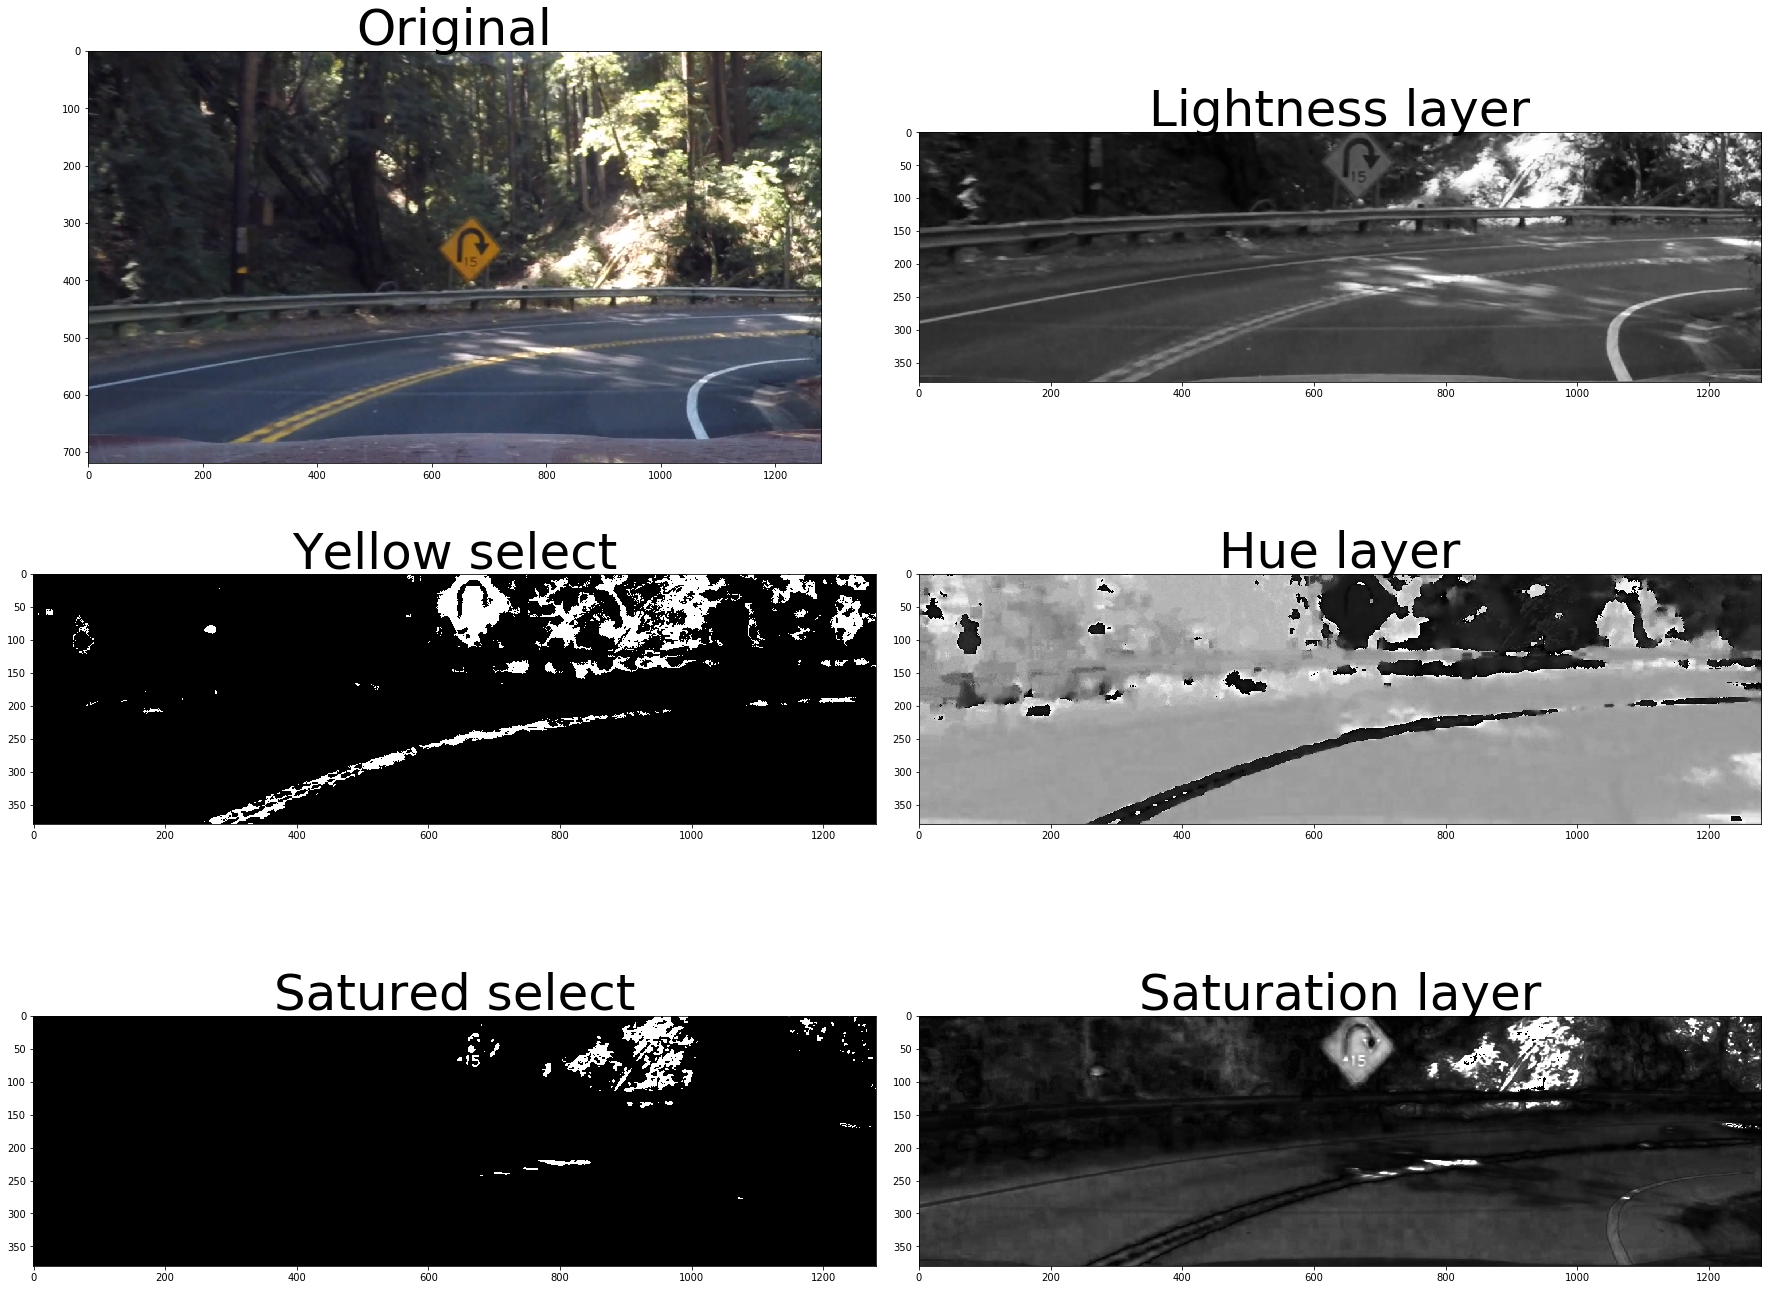

In [231]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def color_thresh(image, thresholds=(0,255)):
    assert len(image.shape) == 2, 'gradient_thresh: image input must be 2D numpy image'
    assert image.dtype == np.uint8, 'color_thresh: image dtype must be numpy.uint8'
    binary = np.zeros_like(image, dtype=np.uint8)
    binary[(image >= thresholds[0]) & (image <= thresholds[1])] = 1
    return binary

# Demonstration of the function
img = mpimg.imread('output_images/hard_turn.png')    # Read to RGB pixel format 
#img = mpimg.imread('test_images/test5.jpg')    # Read to RGB pixel format 

if img.dtype == np.float32:
    img = np.uint8(np.floor(img*255.99))
hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)

# Apply function
stripe = range(300,680)
mask_hue = color_thresh(hls[stripe,:,0],(16,22))
mask_sat = color_thresh(hls[stripe,:,2],(192,255))

# Display images
f, ((ax0,axh), (ax1, ax2), (ax3, ax4)) = plt.subplots(3, 2, figsize=(24, 20))
f.tight_layout()
ax0.imshow(img)
ax0.set_title('Original', fontsize=50)
axh.imshow(hls[stripe,:,1], cmap='gray')
axh.set_title('Lightness layer', fontsize=50)
ax1.imshow(mask_hue, cmap='gray')
ax1.set_title('Yellow select', fontsize=50)
ax2.imshow(hls[stripe,:,0], cmap='gray')
ax2.set_title('Hue layer', fontsize=50)
ax3.imshow(mask_sat, cmap='gray')
ax3.set_title('Satured select', fontsize=50)
ax4.imshow(hls[stripe,:,2], cmap='gray')
ax4.set_title('Saturation layer', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Clean up workspace
del ax0, axh, ax1, ax2, ax3, ax4, f, hls, img, mask_hue, mask_sat

Next we will apply multicriteria thresholding to robustly identify the lane lines. We can discard the top half of each image immediately after correcting distortion, because if the pavement is in the top half, the car is on its roof and we have to control whacorners, gray, images, objptsoever on its trajectory.

The code performs color space conversion to HSL colorspace, in order to be robust to changes in lighting in shaded areas. We expect that shade information will get concentrated in the L component, and that hue H and saturation S components will not be affected too much. We will also attempt to capture the information that some lines are yellow (although the meaning is not standardized, since the color would be used for temporary markings during road construction works in Europe, for instance).

Detection of the lane lines in HSL components is performed by thresholding functions, which take HSL encoded image as input.

In order to reduce the probability of having moise pixels at the same location on several binary images, the images are despeckled with the `erode` operator.

In [ ]:
import numpy as np

class RoadImage(np.ndarray):
    """
    road_image is a subclass of numpy ndarray, which offers specialized operations to process such images and
    extract features or compute the location of the vehicle relative to the road.
    In addition to depending on numpy, the implementation depends on OpenCV2.
    Subclassing numpy.ndarray is explained in https://docs.scipy.org/doc/numpy-1.13.0/user/basics.subclassing.html
    """
    import cv2
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    """
    Eliminate isolated noise pixels in binary images. Isolated noise pixels are usually not related to lane lines.
    The class shall be used as a function: out = despeckle(in)
    despeckle is a singleton class which avoids having global constants for the kernels, or redefining them at each call.
    """
        
        
    kernel1 = np.array([[1,0,0],[0,1,0],[0,0,1]], dtype=np.uint8)
    kernel2 = np.array([[0,0,1],[0,1,0],[1,0,0]], dtype=np.uint8)
    
    def __new__(cls, image=None, mtx=None, dist=None, file=None):
        """
        __new__ is called with cls set to the class object, and the same arguments as the constructor.
        Its typical use is to implement class-specific memory management.
        __new__ is called when the program makes a direct call to the RoadImage constructor. It has to
        call super().__new__, which will call back __array_finalize__ with obj set to None.
        __init__ is called with self set to whatever object __new__ returns, so we return what super() returns.
        """
        if (image is None) and (file is None):
            raise ValueError('RoadImage: must pass one of image or file to constructor.')
        # Cast to cls will call __finalize_array__
        obj = np.asarray(input_array).view(cls)
        
        
    def __init__(self, image=None, mtx=None, dist=None, file=None):
        """
        The correct way to call the constructor, is to pass it and already constructed numpy array in image.
        Alternately, it is possible to pass it a filename, and it will be loaded from a file using mpimg.
        Because __new__ is always called before, there is no need to check everything again here.
        """
        self.filename = file
        if image is None:
            image = mpimg.imread(file)    # Read RGB image. Will throw exception on error
        
        obj = np.asarray(image).view(cls)
        assert binary.dtype == np.uint8, 'despeckle: wrong data type. Operates on np.int8 numpy images.'
        super(despeckle,self).__init__(shape=binary.shape,dtype=np.uint8)
        # Clean masks
        out1 = cv2.erode(binary, kernel1)
        out2 = cv2.erode(binary, kernel2)
        sums = np.sum(np.stack([out1, out2, binary], axis=2))
        self.out = np.zeros_like(binary)
        self.out[(sums>=2)]=1
        
    def __finalize_array__(self, obj):
        """
        This method is always called when an instance is created. Numpy supports three ways of creating instances.
        1) Calling the constructor directly  (this method is called via __new__ and super().__new__, obj is None)
        2) Taking a slice
        3) Casting a numpy array to RoadImage using np.ndarray.view(RoadImage)
        In case 2 and 3, obj is the instance to cast or the one used to build the slice.
        """
        if obj is None:
            # The constructor did all the work
            return
        # Copy class specific attributes of slices, and set defaults for casts
        # Note that if an attribute exists in obj, it does not prove that the semantics are the same
        if type(obj) is RoadImage:
            # Copy attributes when semantics are known
            self.file = getattr(obj, 'file', None)
        return

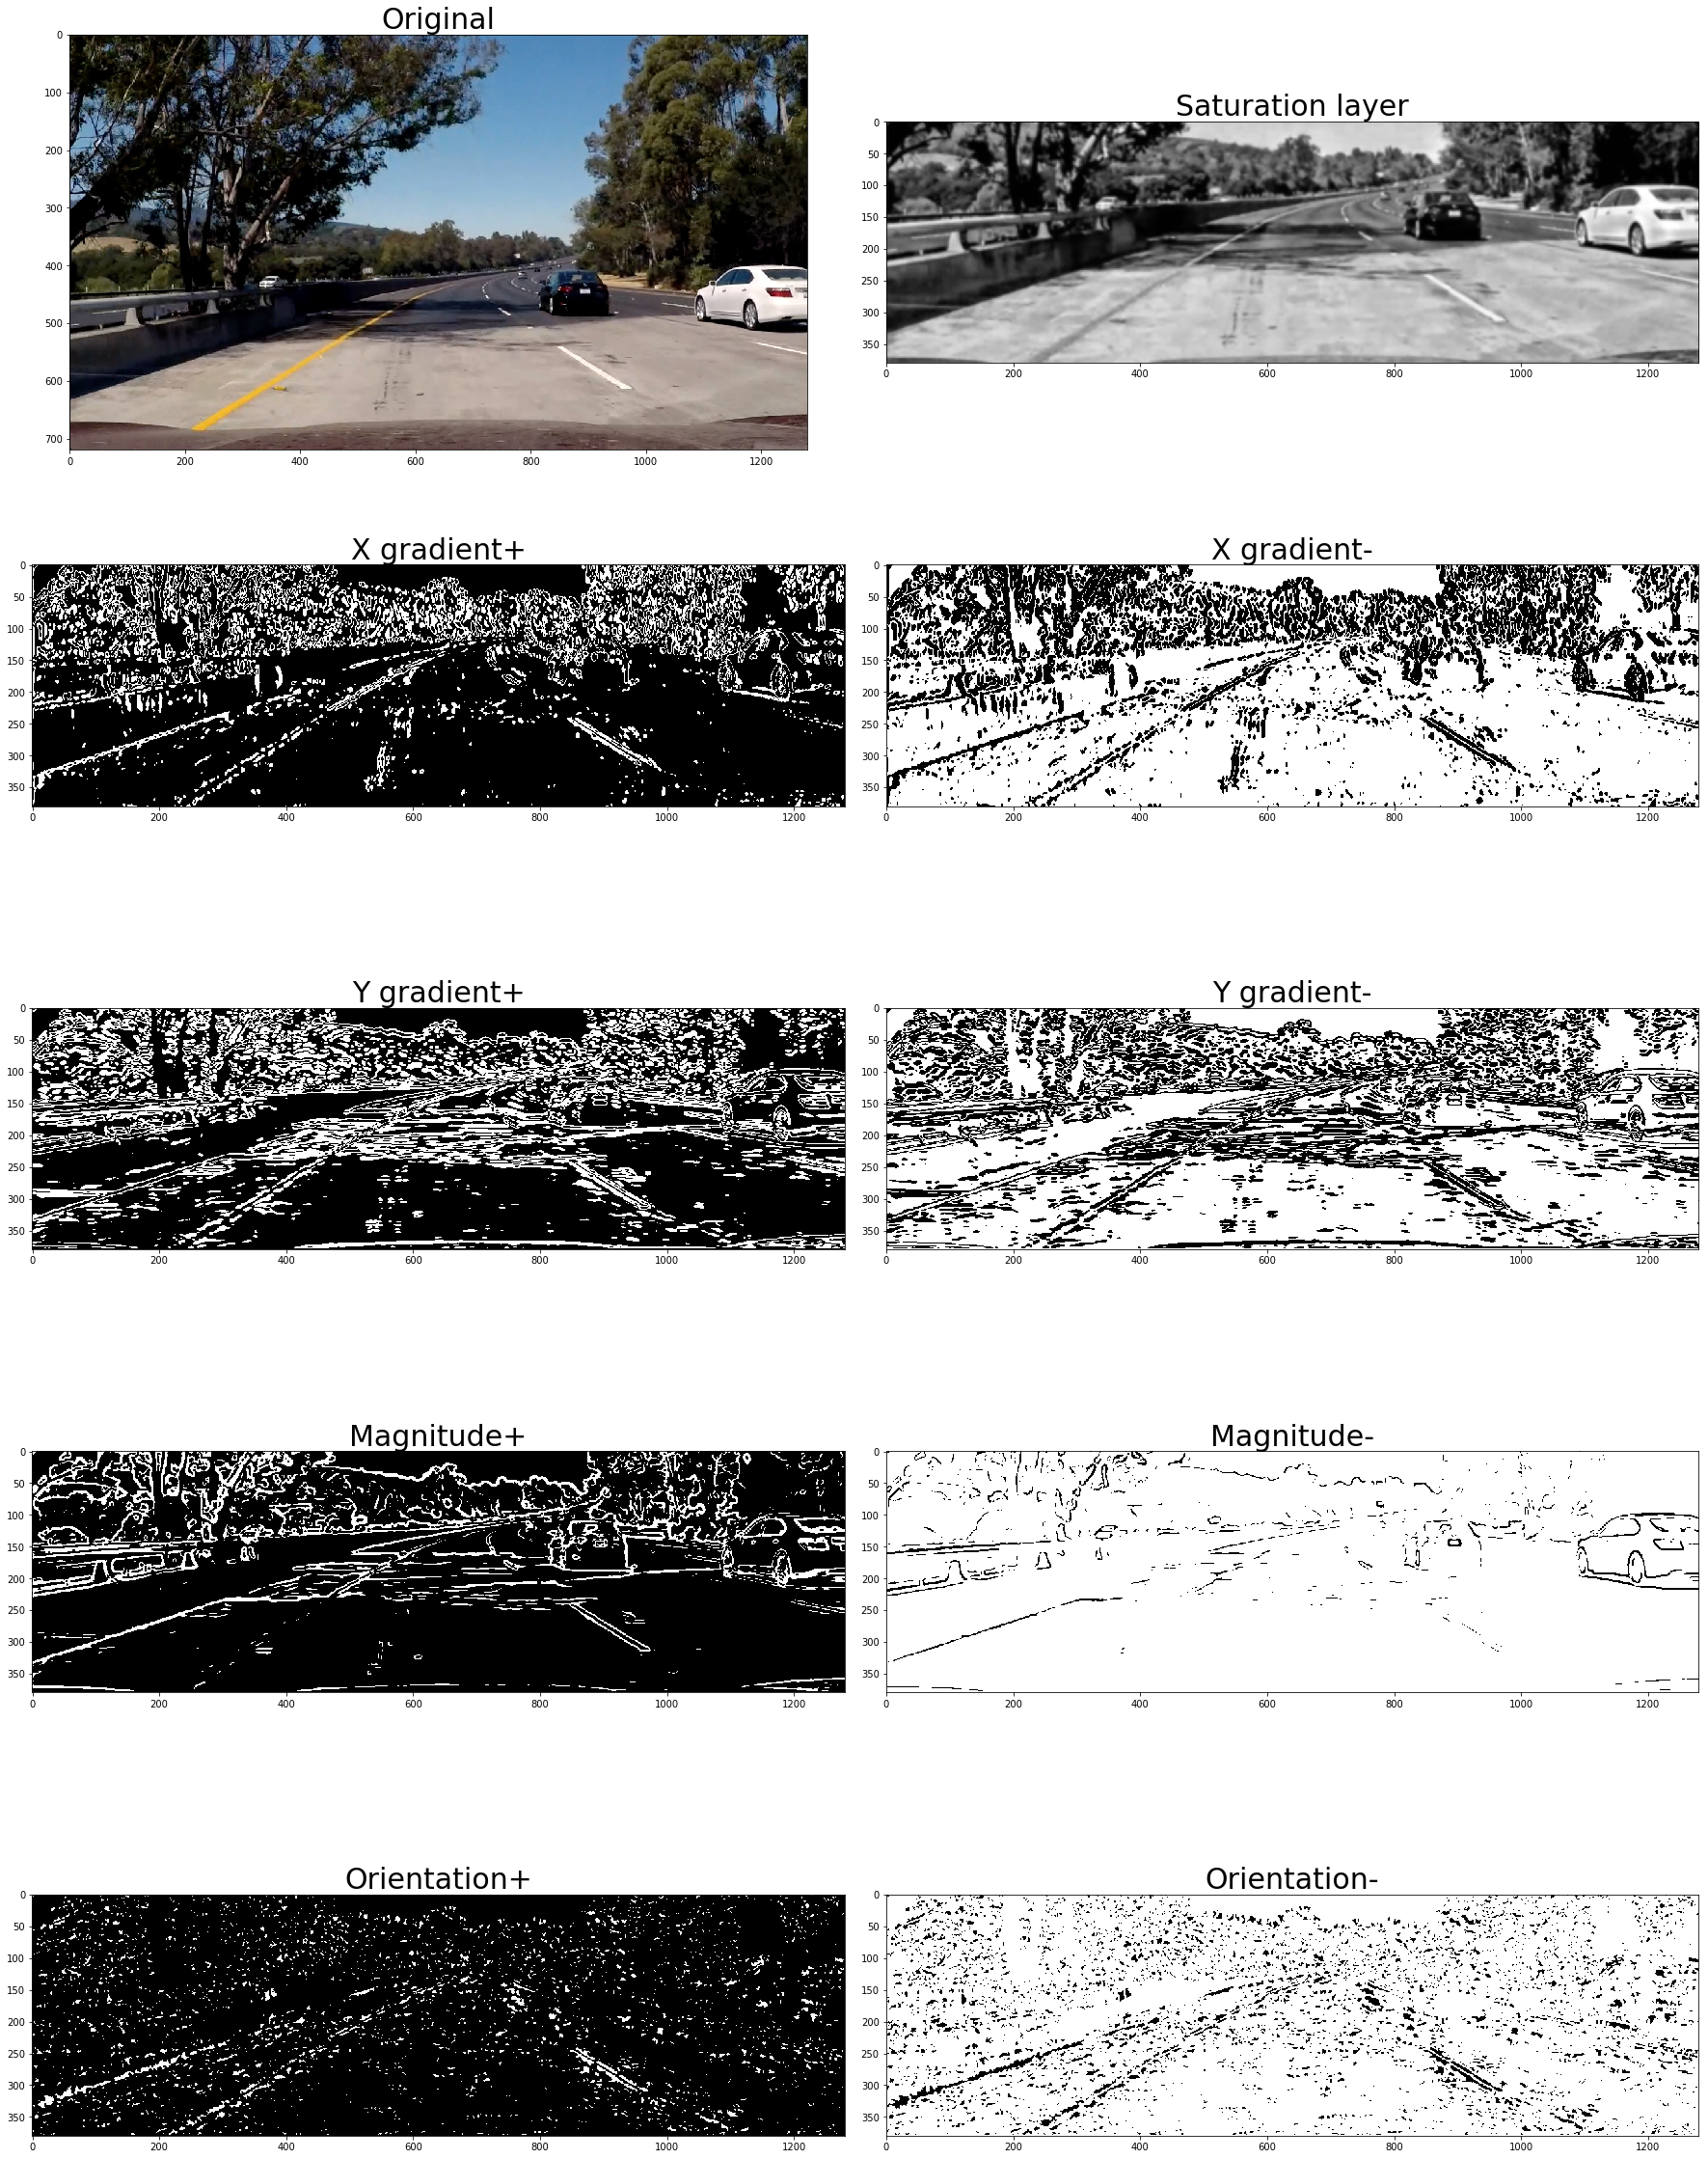

In [481]:

# Gradient thresholding function

# Accepts a RGB image as input, and generate several bitmasks with the same dimensions as output.
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def gradient_thresh(image, tasks=['x','y','mag','angle'], thresh=[(0, 255)]*4, sobel_kernel=9, minmag=10):
    """
    The unique function computes the gradient components alongside x and y directions, and
    outputs the requested masks obtained by the application of the specified thresholds to the gradient based 
    quantities.
    image is a single channel 2D image (channel 0 of color images is used: usually it will be the red channel)
    tasks is a list of tags, by default all available tags are returned.
    thresh is a list of tuples giving the min and max thresholds corresponding to each tag, in the same order.
    sobel_kernel is the size of the kernel used to compute the gradient (n x n). 
    minmag is a minimum magnitude applied as an additional condition to the angle task.
    Returns the binary masks in the same order as they appear in tasks. None is returned when unsupported 
    
    """
    assert len(thresh) >= len(tasks), 'gradient_thresh: supply one threshold tuple per requested task.'
    # Apply the following steps to img
    # 1) Select channel
    if len(image.shape) == 3:
        assert image.shape[2] <= 3 , 'gradient_thresh: more than 3 channels ? Check that channel order is [height,width,color].'
        gray = image[:,:,0]
        print('gradient_thresh')
    else:
        assert len(image.shape) == 2, 'gradient_thresh: image input must be 2D numpy image'
        gray = image
        
    # 2) Take the derivative in x and y (one or both can be optimised out according to requested tasks)
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    if ('x' in tasks) or ('mag' in tasks) or ('angle' in tasks):
        derx = cv2.Sobel(gray, cv2.CV_32F, 1, 0)
        abs_derx = np.abs(derx)
    if ('y' in tasks) or ('mag' in tasks) or ('angle' in tasks):
        dery = cv2.Sobel(gray, cv2.CV_32F, 0, 1)
        abs_dery = np.abs(dery)
        
    # Generate outputs
    masks = [None]*len(tasks)
    
    if 'x' in tasks:
        # 5x) Create a mask of 1's where the scaled gradient magnitude 
        # is > thresh_min and < thresh_max
        index = tasks.index('x')
        thresholds = thresh[index]
        # 6) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scale = 10 * np.median(abs_derx)
        scaled = np.uint8(np.minimum(255.0,np.floor(abs_derx*(255.99 / scale))))
        masks[index] = color_thresh(scaled, thresholds)
    
    if 'y' in tasks:
        # 5y) Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
        index = tasks.index('y')
        thresholds = thresh[index]
        # 6) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scale = 10 * np.median(abs_dery)
        scaled = np.uint8(np.minimum(255.0,np.floor(abs_dery*(255.99 / scale))))
        masks[index] = color_thresh(scaled, thresholds)
    
    if ('mag' in tasks) or ('angle' in tasks):
        # 5) Calculate the magnitude (also used by 'angle' below)
        grad = np.sqrt(abs_derx * abs_derx + abs_dery * abs_dery)
        # 6) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_grad = np.uint8(np.floor(grad*(255.99/np.max(grad))))
        if 'mag' in tasks:
            # 6mag) Extract thresholds from thresh list
            index = tasks.index('mag')
            thresholds = thresh[index]
            masks[index] = color_thresh(scaled_grad, thresholds)
    
    if 'angle' in tasks:
        # 5angle) Extract thresholds from thresh list
        index = tasks.index('angle')
        thresholds = thresh[index]
        # 6) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
        angle = np.arctan2(abs_dery, abs_derx)
        # Arctan2 returns value between 0 and np.pi/2 which are scaled to [0,255]
        scaled = np.uint8(np.floor(angle*(255.99/(np.pi/2))))
        binary = color_thresh(scaled, thresholds)
        # Apply additional magnitude criterion
        binary[(scaled_grad < minmag)] = 0
        masks[index] = binary
       
    # Return output masks
    return masks

# Demonstration of the above function
img = mpimg.imread('test_images/test5.jpg')    # Read to RGB pixel format 
hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)

# Apply function                          
#layer = hls[300:680,:,0]
#layer = cv2.GaussianBlur(layer,(5,5),0)
#layer = cv2.GaussianBlur(layer,(9,9),0)
# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32,32))
lum = hls[300:680,:,1]
layer = clahe.apply(lum)
layer = cv2.GaussianBlur(layer,(9,9),0)
#layer = cv2.GaussianBlur(hls[300:680,:,2],(5,5),0)
#layer = hls[300:680,:,2]

(xmask, ymask, magmask, anglemask) = gradient_thresh(layer, 
                                                     thresh=[(80,250),(50,200),(40,190),(140,220)])
(xmask2, ymask2, magmask2, anglemask2) = gradient_thresh(layer, 
                                                     thresh=[(60,255),(40,210),(80,240),(130,230)])
# Hue    Magnitude
# certain (8,14)
# all     (5,17)

# Luminance Xmask  Ymask   Magnitude  Orientation
# certain
# all
%matplotlib inline

# Clean masks
kernel = np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=np.uint8)

# Display images
f, ((ax0,axh), (ax1p, ax1n), (ax2p, ax2n), (ax3p, ax3n), (ax4p, ax4n)) = plt.subplots(5, 2, figsize=(24, 35))
f.tight_layout()

def nop(image, kernel):
    return image
    
#erode = nop
erode = cv2.erode

ax0.imshow(img)           
ax0.set_title('Original', fontsize=30)
axh.imshow(layer, cmap='gray')
axh.set_title('Saturation layer', fontsize=30)

ax1p.imshow(xmask, cmap='gray')
ax1p.set_title('X gradient+', fontsize=30)
ax1n.imshow(1-xmask2, cmap='gray')
ax1n.set_title('X gradient-', fontsize=30)

ax2p.imshow(ymask, cmap='gray')
ax2p.set_title('Y gradient+', fontsize=30)
ax2n.imshow(1-ymask2, cmap='gray')
ax2n.set_title('Y gradient-', fontsize=30)

ax3p.imshow(erode(magmask,kernel), cmap='gray')
ax3p.set_title('Magnitude+', fontsize=30)
ax3n.imshow(1-erode(magmask2,kernel), cmap='gray')
ax3n.set_title('Magnitude-', fontsize=30)

ax4p.imshow(erode(anglemask,kernel), cmap='gray')
ax4p.set_title('Orientation+', fontsize=30)
ax4n.imshow(1-erode(anglemask2,kernel), cmap='gray')
ax4n.set_title('Orientation-', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Clean up workspace
del ax0, axh, ax1p, ax1n, ax2p, ax2n, ax3p, ax3n, ax4p, ax4n, f, hls, img
del xmask, ymask, magmask, anglemask, xmask2, ymask2, magmask2, anglemask2, kernel, layer, plt

try:
    del lum
except NameError:
    pass

try:
    del hue
except NameError:
    pass

try:
    del clahe
except NameError:
    pass

In order to implement robust line detection, we will combine multiple detection methods based on gradients and value thresholds. However, gradients detect the edge of flat colored areas, so we have here a function which fills gradient images using an add/even algorithm line by line.

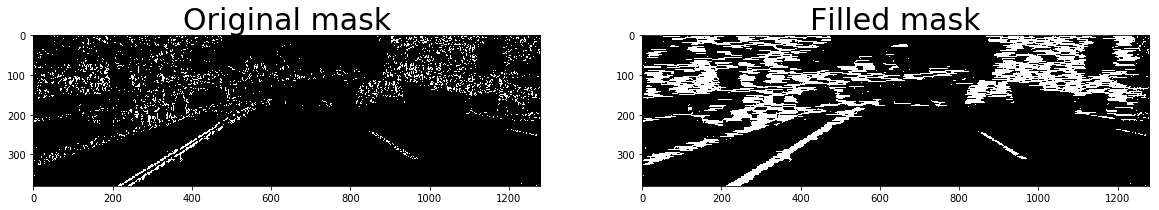

In [130]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def fill_gradient(img, max_line_width=50):
    """
    Accepts a gradient binary image, and fills the pixels between two input pixels situated on the same line, if 
    and only if the distance between them is acceptable for a lane line.
    """
    out = np.copy(img)
    for line in out:
        x = 0
        count = 0
        pixel = 1
        while x < out.shape[1] - max_line_width:
            if count == max_line_width - 1:
                pass
            elif line[x] != 0:
                if count == 0: pixel = line[x]
                # Increment counter of contiguous white pixels
                count += 1
            elif count > 0:
                window = line[x:x+max_line_width-count]
                match = np.argmax(window[::-1])
                if match > 0:
                    match = max_line_width-count-match
                    window[:match-1] = pixel
                    x += match
                count = 0
            x += 1 
    return out

# Demonstration of the above function
img = mpimg.imread('test_images/test5.jpg')    # Read to RGB pixel format 
hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)

# Apply function                          
(xmask,) = gradient_thresh(hls[300:680,:,2], tasks=['x'], thresh=[(10,120)])

# Clean and fill gradient mask
kernel = np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=np.uint8)
xmask = cv2.erode(xmask, kernel)
xfilled = fill_gradient(xmask)

%matplotlib inline

# Visualize masks
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(xmask, cmap='gray')
ax1.set_title('Original mask', fontsize=30)
ax2.imshow(xfilled, cmap='gray')
ax2.set_title('Filled mask', fontsize=30)

# Clean up workspace
del ax1, ax2, f, kernel, xmask, img, hls, xfilled

We now have all the tools to implement a majority voting system which will extract the lane lines. Confidence is iteratively estimated by comparison of the solution with each image source.

The various masks are merely summed, and the resulting image is thresholded, in order to implement the majority voting. If the iterate parameter is true, the weights of each input mask are automatically varied to reduce the weight of the masks which are farther away from the voted solution. The number of iterations is bounded.

All the lane lines are extracted first, then a yellow line mask is used to tag yellow line pixels.

6 3021.0


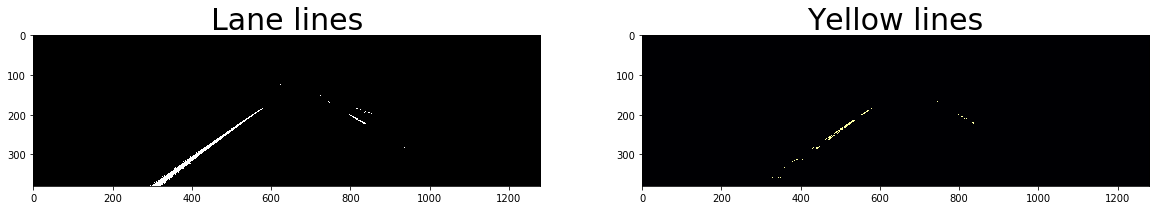

In [411]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Global constant
# Default image mask
#DEFAULT_MASK = mpimg.imread('output_images/straight_mask.png')   # binary PNG
def iterative_vote(inputs, minvote=0.1):
    """
    inputs is a multichannel int8 image where each channel is the result of a lane line detection attempt.
           uncertain pixels should be 0, certain lane pixels should be 1, certain not lane pixels should be -1.
    The iterative vote does a weighted sum of the inputs, and tries to find a subset which is a good predictor
    of the results.
    minvote is a threshold for votes. Pixels with a weighted sum greater than minvote will
    be ones, all the other will be zeroes. If minvote is negative, only pixels which cannot be lane lines will be 
    unlit.
    """
    nb_inputs = inputs.shape[2]
    # Initialize and normalize weights
    weights = np.ones(nb_inputs).reshape((nb_inputs,1)) / nb_inputs
    
    # Iterate maximum N times
    if iterate:
        iterate=6
    else:
        iterate=1
    
    binary = np.zeros_like(inputs[:,:,0], dtype=np.uint8)
    for i in range(iterate):
        #print(np.transpose(weights))
        votes = np.dot(inputs,weights).reshape(binary.shape)
        binary[(votes>minvote)] = 1
        if i<iterate-1:
            # Recompute weights according to 'correctly found' pixels noralized by 
            sums = [np.sum(inputs[:,:,j]) for j in range(nb_inputs)]
            #print(sums)
            oldweights = np.copy(weights)
            for j in range(nb_inputs):
                if sums[j] > 0:
                    weights[j,0] = np.sum(binary[(inputs[:,:,j]==1)])/sums[j]
                else:
                    weights[j,0] = 0.0
            weights /= np.sum(weights)
            if np.max(np.abs(weights-oldweights))<0.01: break
            del oldweights
            binary[:,:] = 0
    return binary

def extract_lane_lines(img, mask=None, yellow=False, iterate=False, stripe = range(300,680), minvote=0.35):
    """
    Returns one (two if yellow=True) binary images containing mostly pixels belonging to the lane lines, which
    are detected using multiple criteria on the input image.
    img: a RGB encoded image, compensated for camera distortion.5.
    mask: an optional mask with ones in the areas where lane lines can be. It is used to eliminate noise
        in the input image, and also to select pixels which are counted in the vote.
        Defaults to global constant DEFAULT_MASK, which is a binary numpy array.
    yellow: whether to apply yellow line detection. A second bitmap is output when yellow is true. Defaults to False.
    iterate: controls whether vote is refined by giving weights to vote inputs.
    stripe: a range of lines to consider in img. Defaults to range(300,680).
    minvote: minimum weighted sum to keep pixels (a percentage) 
    """
    #if mask is None:
    #    mask = DEFAULT_MASK[:,:,0].reshape(DEFAULT_MASK.shape[:2])
    #assert mask.shape == img.shape[:2], 'extract_lane_lines: mask and img dimensions differ.'
    #mask = mask[stripe]
    
    # 1) Convert region of interest to HLS color space
    hls = cv2.cvtColor(img[stripe],cv2.COLOR_RGB2HLS)
    # 2) Extract all the gradients
    # Hue
    hue = cv2.GaussianBlur(hls[:,:,0],(9,9),0)
    layer = cv2.GaussianBlur(hue,(9,9),0)
    (magmaskH,) = gradient_thresh(layer, tasks=['mag'], thresh=[(35,65)])
    # Luminance
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32,32))
    lum = hls[:,:,1]
    layer = clahe.apply(lum)
    layer = cv2.GaussianBlur(layer,(9,9),0)
    #(xmaskL, ymaskL, magmaskL, anglemaskL) = gradient_thresh(layer, thresh=[(100,230),(50,200),(80,190),(140,220)])
    (magmaskL, ) = gradient_thresh(layer, tasks=['mag'], thresh=[(100,230),(50,200),(80,190),(140,220)])
    # Saturation
    sat = hls[:,:,2]
    layer = cv2.GaussianBlur(sat,(5,5),0)
    #(xmaskS, ymaskS, magmaskS, anglemaskS) = gradient_thresh(layer, thresh=[(110,225),(120,225),(240,255),(140,192)])
    (anglemaskS,) = gradient_thresh(layer, tasks=['angle'], thresh=[(110,225),(120,225),(240,255),(140,192)])

    # 3) Clean up and fill gradients
    kernel = np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=np.uint8)
    
    def nop(image, kernel):
        return image
    
    #erode = nop
    erode = cv2.erode
    #magmaskH = fill_gradient(nop(magmaskH,kernel))
    #xmaskL = fill_gradient(nop(xmaskL,kernel))
    #ymaskL = fill_gradient(nop(ymaskL,kernel))
    #magmaskL = fill_gradient(nop(magmaskL,kernel))
    #anglemaskL = fill_gradient(nop(anglemaskL,kernel))
    #xmaskS = fill_gradient(nop(xmaskS,kernel))
    #ymaskS = fill_gradient(nop(ymaskS,kernel))
    #magmaskS = fill_gradient(erode(magmaskS,kernel))
    #anglemaskS = fill_gradient(erode(anglemaskS,kernel))
    # 4) Extract colors
    # TODO: move hardcoded thresholds to thresh or global constants
    huemask = color_thresh(hls[:,:,0],(16,22))
    satmask = color_thresh(hls[:,:,2],(192,255))
    
    # 6) Iterative votes
    # Stack inputs : all gradients
    inputs = np.stack([magmaskH,
                       xmaskL,ymaskL,magmaskL,anglemaskL,
                       xmaskS,ymaskS,magmaskS,anglemaskS], axis=2).astype(np.int8)
    # Analysis of the weights shows that magmaskL, anglemaskS and satmask are the best predictors.
    #inputs = np.stack([magmaskL,anglemaskS,satmask], axis=2)

    #print(np.transpose(weights),'',end='')
         
    # 7) Detect yellow lines
    if yellow:
        yellow_out = np.copy(binary)
        yellow_out[(huemask==0) | (magmaskH==0)] = 0   # turn off non-yellow lines
        return binary, yellow_out

    return binary

# Demonstration
img = mpimg.imread('test_images/test6.jpg')    # Read to RGB pixel format 

#print(img.shape, DEFAULT_MASK.shape)
for vote in range(6,7,1):
    lanes, yellow = extract_lane_lines(img, yellow=True, iterate=True, minvote=vote/10.)
    print(vote,np.sum(lanes))

# Visualize masks
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(lanes, cmap='gray')
ax1.set_title('Lane lines', fontsize=30)
ax2.imshow(yellow, cmap='inferno')
ax2.set_title('Yellow lines', fontsize=30)

del ax1, ax2, f, lanes, yellow, img

Yellow line detection is interesting, because we know that if we substract the yellow lines from the bitmap with all the lines, we will get only the white lines.

The hardcoded vote threshold has an influence on the number of detected pixels. 
A parametric analysis of the parameter shows that the number of detected pixel decreases step by step, each step corresponding to a stable detection. With a very high threshold, the only detected pixels are the pixels which are
lit on all the input layers. If for some reason one of the layers fails to see the lanes, we can expect that the
signal will disappear completely. This is not a robust detection.

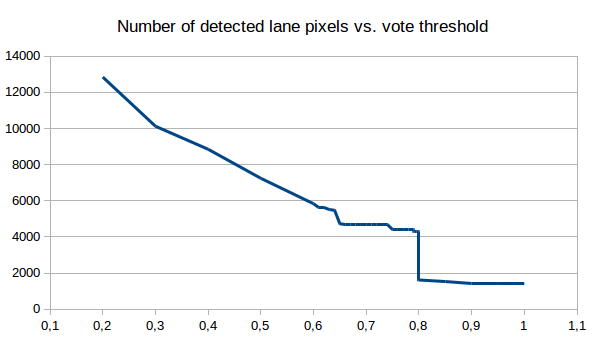

For values of the threshold lower than approximately 0.64, the number of selected pixels increases regularly, as more and more "noise" pixels are added. There is a flat area on the curve with approximately 5000 pixels selected. This is a stable detection, which corresponds to the true lane lines. The final value of the threshold has been chosen to fall in the middle of the plateau : 0.72.

The next cell visualizes the detected lanes on several other test images.

[[ 0.26959976  0.11413767  0.61626258]] [[ 0.02500045  0.13886084  0.8361387 ]] [[ 0.08287119  0.06112265  0.85600616]] [[ 0.17594749  0.17093615  0.65311636]] [[ 0.2274602   0.18110158  0.59143822]] [[ 0.23278923  0.18927427  0.57793651]] [[ 0.12820258  0.23880476  0.63299266]] [[ 0.4823411   0.17688751  0.34077138]] [[ 0.06849698  0.85469739  0.07680563]] 

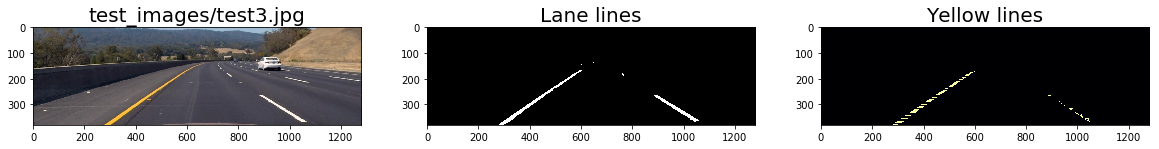

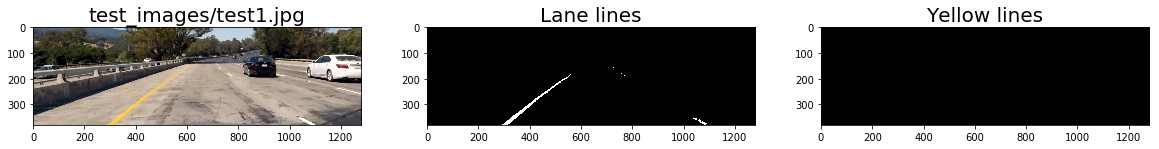

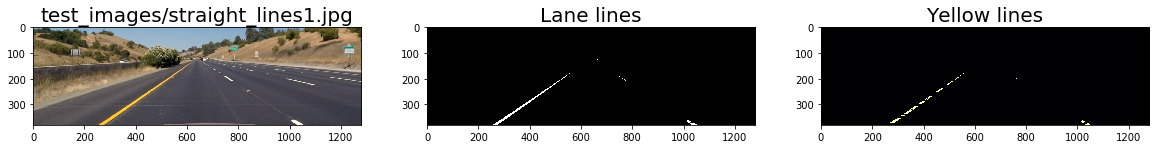

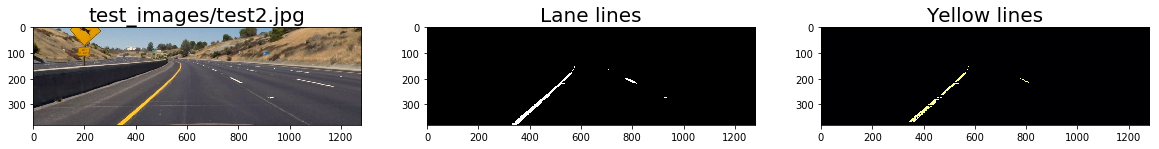

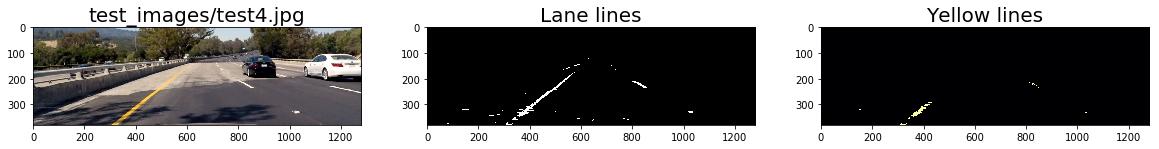

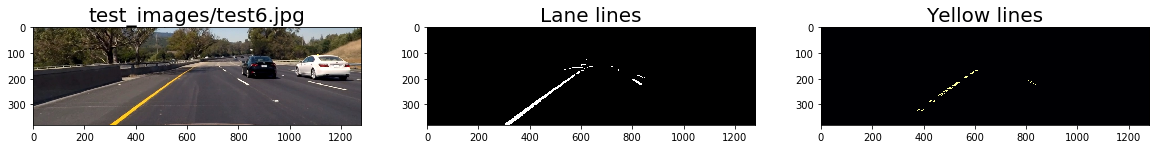

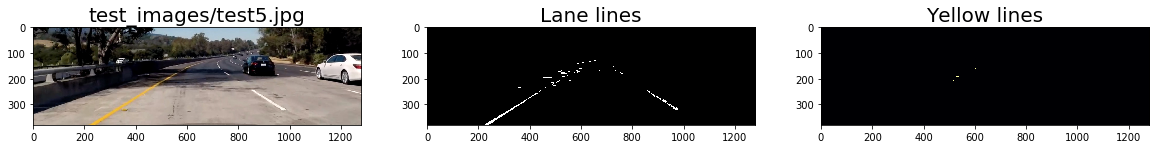

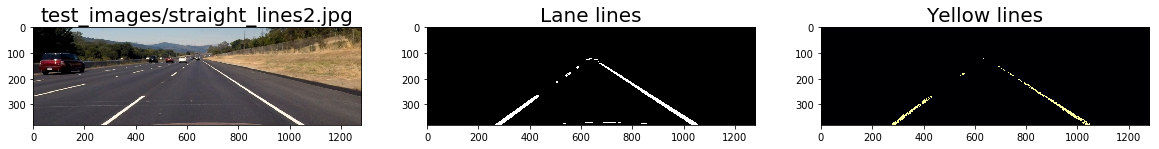

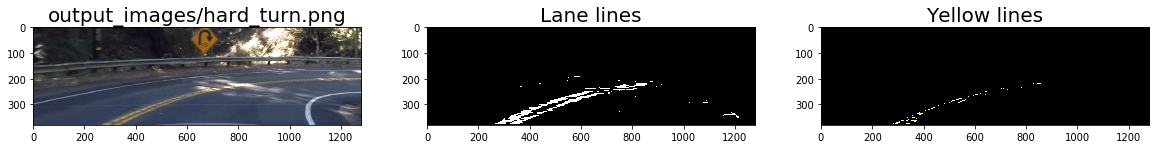

In [400]:
# Application to the test images
# Make a list of calibration images
images = glob.glob('test_images/*.jpg')
images.append('output_images/hard_turn.png')

for filepath in images:
    img = mpimg.imread(filepath)    # Read to RGB pixel format 
    filename = filepath[filepath.index('/')+1:-4]
    if img.dtype == np.float32:
        img = np.uint8(np.floor(img*255.99))
    # Undistort
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    # Extract lane lines
    lanes, yellow = extract_lane_lines(dst, yellow=True, iterate=True)
    mpimg.imsave('output_images/lanes_'+filename+'.png',lanes,format='png')
    mpimg.imsave('output_images/yellow_'+filename+'.png',yellow,format='png')
    
    # Visualize masks
    f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,10))
    ax0.imshow(dst[300:680])
    ax0.set_title(filepath, fontsize=20)
    ax1.imshow(lanes, cmap='gray')
    ax1.set_title('Lane lines', fontsize=20)
    ax2.imshow(yellow, cmap='inferno')
    ax2.set_title('Yellow lines', fontsize=20)

del ax0, ax1, ax2, f, lanes, yellow, img, images, filename

---

The next stage of analysis operates in a bird-eye view of the road. A view from above will make it a lot easier to calculate the geometry of the road ahead, especially the position of the car in the lane and the curvature of the road.

In order to get this view, we can rely on OpenCV's `warpPerspective` function. We will just assume that the road ahead lays in a plane having the exact same orientation as the road portion the car sits on. If this assumption isn't true, the lane lines will not be parallel, so we can possibly iterate later to fix that.

Given that assumption, an elongated rectangle of straight road ahead of the car looks like a trapeze in the camera image. We only need to find that trapeze on a suitable stretch of road, and project its four corners on the four corners of an elongated rectangle, representing the road seen from above. 

We will also take the opportunity of this projection to set the scale of the image. The height of the camera above the road sets the scale for everything else. In order to find an acceptable approximation to this figure, we will assume that the lane in the test image "straight_lines1.jpg" is exactly 3.7 meters. We can expect to have a lot more detail across the road, especially at short ranges, than alongside it, therefore we will employ rectangular pixels in the transformed picture. The resolution across the road must be fine enough to capture the thin lines, so we will pick 0.02 meters. In the direction of the road, 0.1 meters will be enough. A stripe 10 meters wide by 70 meters long will require 500 x 700 pixels.

Some calculations using the camera matrix lead to estimates of the field of view (58°), of the height of the camera above the road and give the pixel coordinates of the vertices defining a trapezoidal area representing a 40m long lane straight ahead. Coordinates are not obvious because the camera axis is slightly offset to the right and top. 

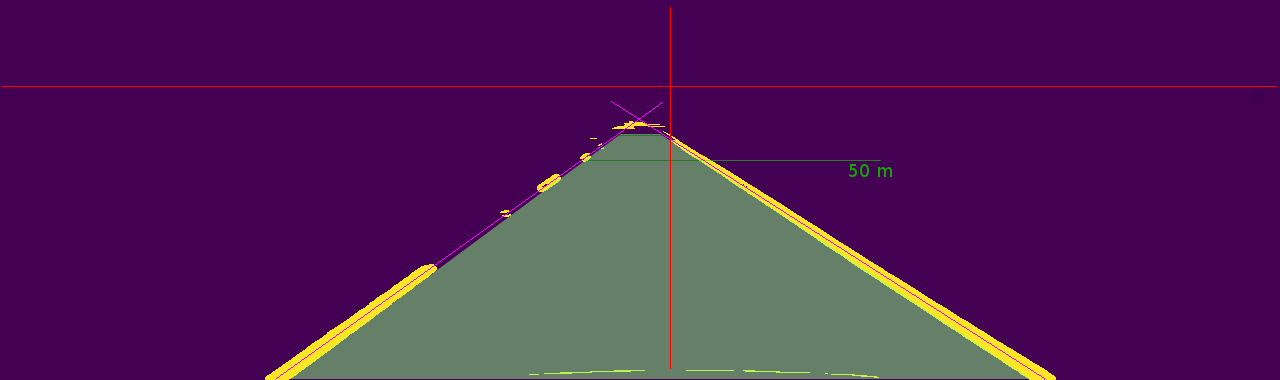
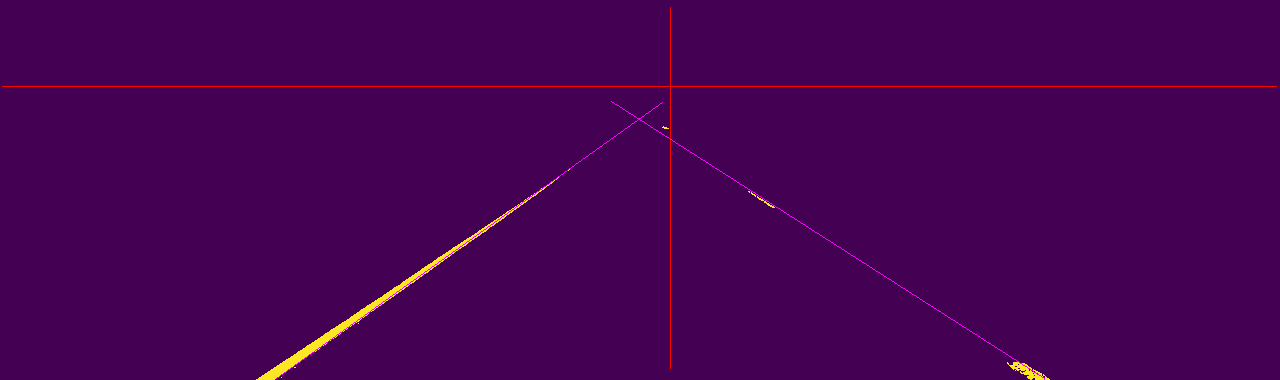

The comparison of the two straight line test images prooves that it is not the trajectory of the car that obliques across the lanes. On the two figures above, which show the lanes extracted from both straight line test images, the magenta lines which are in a separate layer, superpose exactly with the lane lines in both images. The arctangent of the pixel distance, divided by the pixel focal length (found in the camera matrix), gives the angles of misalignment : the camera axis is offset roughly 1.6° to the right and the top from the straight ahead axis defined by the road.

The center of the image is also available in the camera matrix. Taking into account the cropped areas at the top and bottom, the red lines in the figures above cross at the image center, at point (x=670, y=86). Let's consider the vertical plane parallel to the image plane, which meets the ground at the bottom edge of the image. The y coordinate is 379, the last line of the cropped image. The height of the camera axis is 294 pixel lines.

We need a known distance to calculate the scale of everything. The course teaches that the lane width is 3.7 meters. We can observe that the distance is 764 pixel horizontally. Given that those distances are in the same plane parallel to the image plane, the physical distances are proportional to the pixel distances: it gives us the height of the camera above the ground: 1.44 meters (actually the height of the camera axis as it crosses the plane).

Knowing that 3.7 meters appear as 764 pixels, we can convert the focal length to meters using proportionality. The focal length is 5.6 meters. Since the camera is not pointed straight ahead, the camera axis raises above the ground with distance with an angle of 1.6°. At z=70 meters, the small angle adds some to the camera height, which reaches 3.4 meters above the ground. The pixel offset from the image center, is equal to f y/z, using the focal length in pixels to obtain pixels. z can optionally be corrected for the small angle too.

(700, 500, 3)


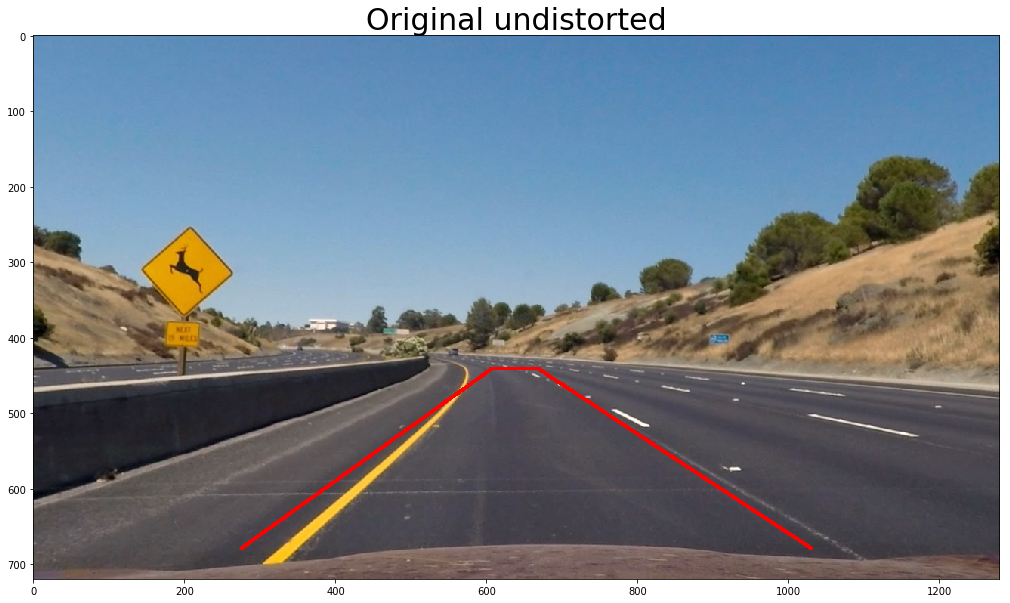

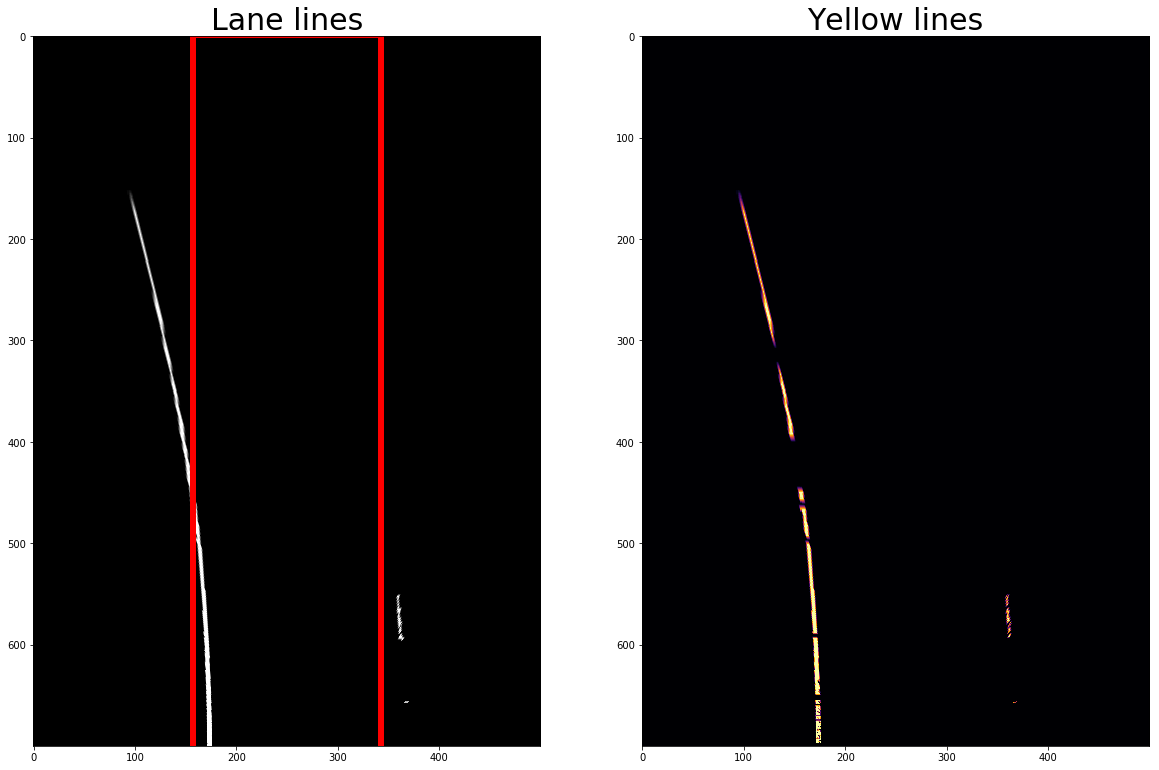

In [455]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Mathematically computed trapeze (could be replaced by formulas for a changing slope)
# 40 m trapeze
#TRAPEZE=np.array([[275,379],[584.6,159.6],[691.4,159.6],[1030,379]], dtype=np.float32)
# 70 m trapeze
TRAPEZE=np.array([[275,379],[607.5,141.8],[668.5,141.8],[1030,379]], dtype=np.float32)
# X scale :  2 cm per pixel
# Y scale : 10 cm per pixel
# Receive 40 m in 400 pixels high image
#LANE=np.array([[157.5,399],[157.5,  0],[342.5,  0],[342.5,399]],  dtype=np.float32)
# Receive 70 m in 700 pixels high image
LANE=np.array([[157.5,699],[157.5,  0],[342.5,  0],[342.5,699]],  dtype=np.float32)

persp_mat = cv2.getPerspectiveTransform(TRAPEZE,LANE)
persp_mat_inv = cv2.getPerspectiveTransform(LANE,TRAPEZE)

def camera_to_birdeye(image,mtx,dist,persp_mat):
    # Undistort
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # Extract lane lines
    lanes, yellow = extract_lane_lines(dst, yellow=True, iterate=True, minvote=0.43)
    # Perspective transform
    birdeye_lanes = cv2.warpPerspective(lanes,  persp_mat, dsize=(500,700))
    birdeye_yellow= cv2.warpPerspective(yellow, persp_mat, dsize=(500,700))
    return birdeye_lanes, birdeye_yellow

# Demonstration
img = mpimg.imread('test_images/test2.jpg')    # Read to RGB pixel format 

lanes, yellow = camera_to_birdeye(img, mtx, dist, persp_mat)

img = cv2.undistort(img, mtx, dist, None, mtx)
# Draw on images
for p1,p2 in zip(TRAPEZE[:3]+[0,300],TRAPEZE[1:]+[0,300]):
    cv2.line(img, tuple(p1.astype(int)), tuple(p2.astype(int)), color=[255,0,0], thickness=3)

show_lanes = cv2.cvtColor(lanes, cv2.COLOR_GRAY2RGB)
for p1,p2 in zip(LANE[:3],LANE[1:]):
    cv2.line(show_lanes, tuple(p1.astype(int)), tuple(p2.astype(int)), color=[1,0,0], thickness=3)

# Visualize masks
plt.figure(figsize=(20,10))
ax1 = plt.subplot(111)
ax1.imshow(img)
ax1.set_title('Original undistorted', fontsize=30)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,15))
ax1.imshow(show_lanes)
ax1.set_title('Lane lines', fontsize=30)
ax2.imshow(yellow, cmap='inferno')
ax2.set_title('Yellow lines', fontsize=30)

del ax1, ax2, f, lanes, yellow, img

The images show lane lines, 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
warped = mpimg.imread('warped_example.jpg')
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML